# Deep Matrix Factorisation 

Matrix factorization with deep layers

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item_withencoder, random_split, user_split_cap, remove_year

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item_withencoder(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,USER,ITEM,RATING,TIMESTAMP
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [16]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [17]:
df_items['cleaned_title'] = df_items['title'].apply(remove_year)
df_items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count,cleaned_title
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,1995.0,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,10878.0,Toy Story
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,1,0,0,1995.0,James Bond must unmask the mysterious head of ...,en,130.0,6.8,2037.0,GoldenEye
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,1,0,0,1995.0,It's Ted the Bellhop's first night on the job....,en,98.0,6.1,1251.0,Four Rooms
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,1995.0,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,501.0,Get Shorty
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,1,0,0,1995.0,An agoraphobic psychologist and a female detec...,en,124.0,6.5,424.0,Copycat


In [18]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [19]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = user_split_cap(DATA, [0.9, 0.1])

In [20]:
train.shape, test.shape

((90009, 5), (9991, 5))

## Deep Matrix Factorization

This is a model with User and Item Embedding Dot Product

In [21]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense, Dropout
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils import model_to_dot
#from reco import vis

### Build the Model

In [22]:
def Deep_MF(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), 
                          embeddings_initializer='glorot_normal',
                          name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), 
                        embeddings_initializer='glorot_normal',
                          name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    Concat = Concatenate(name='Concat')([item_vec, user_vec])
    ConcatDrop = Dropout(0.5)(Concat)

    kernel_initializer='he_normal'
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(10, kernel_initializer='glorot_normal', name="Dense1")(ConcatDrop)
    Dense_1_Drop = Dropout(0.5)(Dense_1)
    Dense_2 = Dense(1, kernel_initializer='glorot_normal', name="Dense2")(Dense_1_Drop)

    
    AddBias = Add(name="AddBias")([Dense_2, item_bias_vec, user_bias_vec])
    
    
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    
    return model

In [23]:
n_factors = 50
model = Deep_MF(n_users, n_items, n_factors)

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbedding (Embedding)     │ (None, 1, 50)             │          84,100 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbedding (Embedding)     │ (None, 1, 50)             │          47,150 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemE (Flatten)        │ (None, 50)                │               0 │ ItemEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserE (Flatten)        │ (None, 50)                │               0 │ UserEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Concat (Concatenate)          │ (None, 100)               │               0 │ FlattenItemE[0][0],        │
│                               │                           │                 │ FlattenUserE[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 100)               │               0 │ Concat[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense1 (Dense)                │ (None, 10)                │           1,010 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 10)                │               0 │ Dense1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemBias (Embedding)          │ (None, 1, 1)              │           1,682 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserBias (Embedding)          │ (None, 1, 1)              │             943 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense2 (Dense)                │ (None, 1)                 │              11 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemBiasE (Flatten)    │ (None, 1)                 │               0 │ ItemBias[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserBiasE (Flatten)    │ (None, 1)                 │               0 │ UserBias[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ AddBias (Add)                 │ (None, 1)                 │               0 │ Dense2[0][0],              │
│                               │                           │                 │ FlattenItemBiasE[0][0],    │
│                               │                           │               

 Total params: 134,896 (526.94 KB)

 Trainable params: 134,896 (526.94 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from reco.recoutils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/model-img


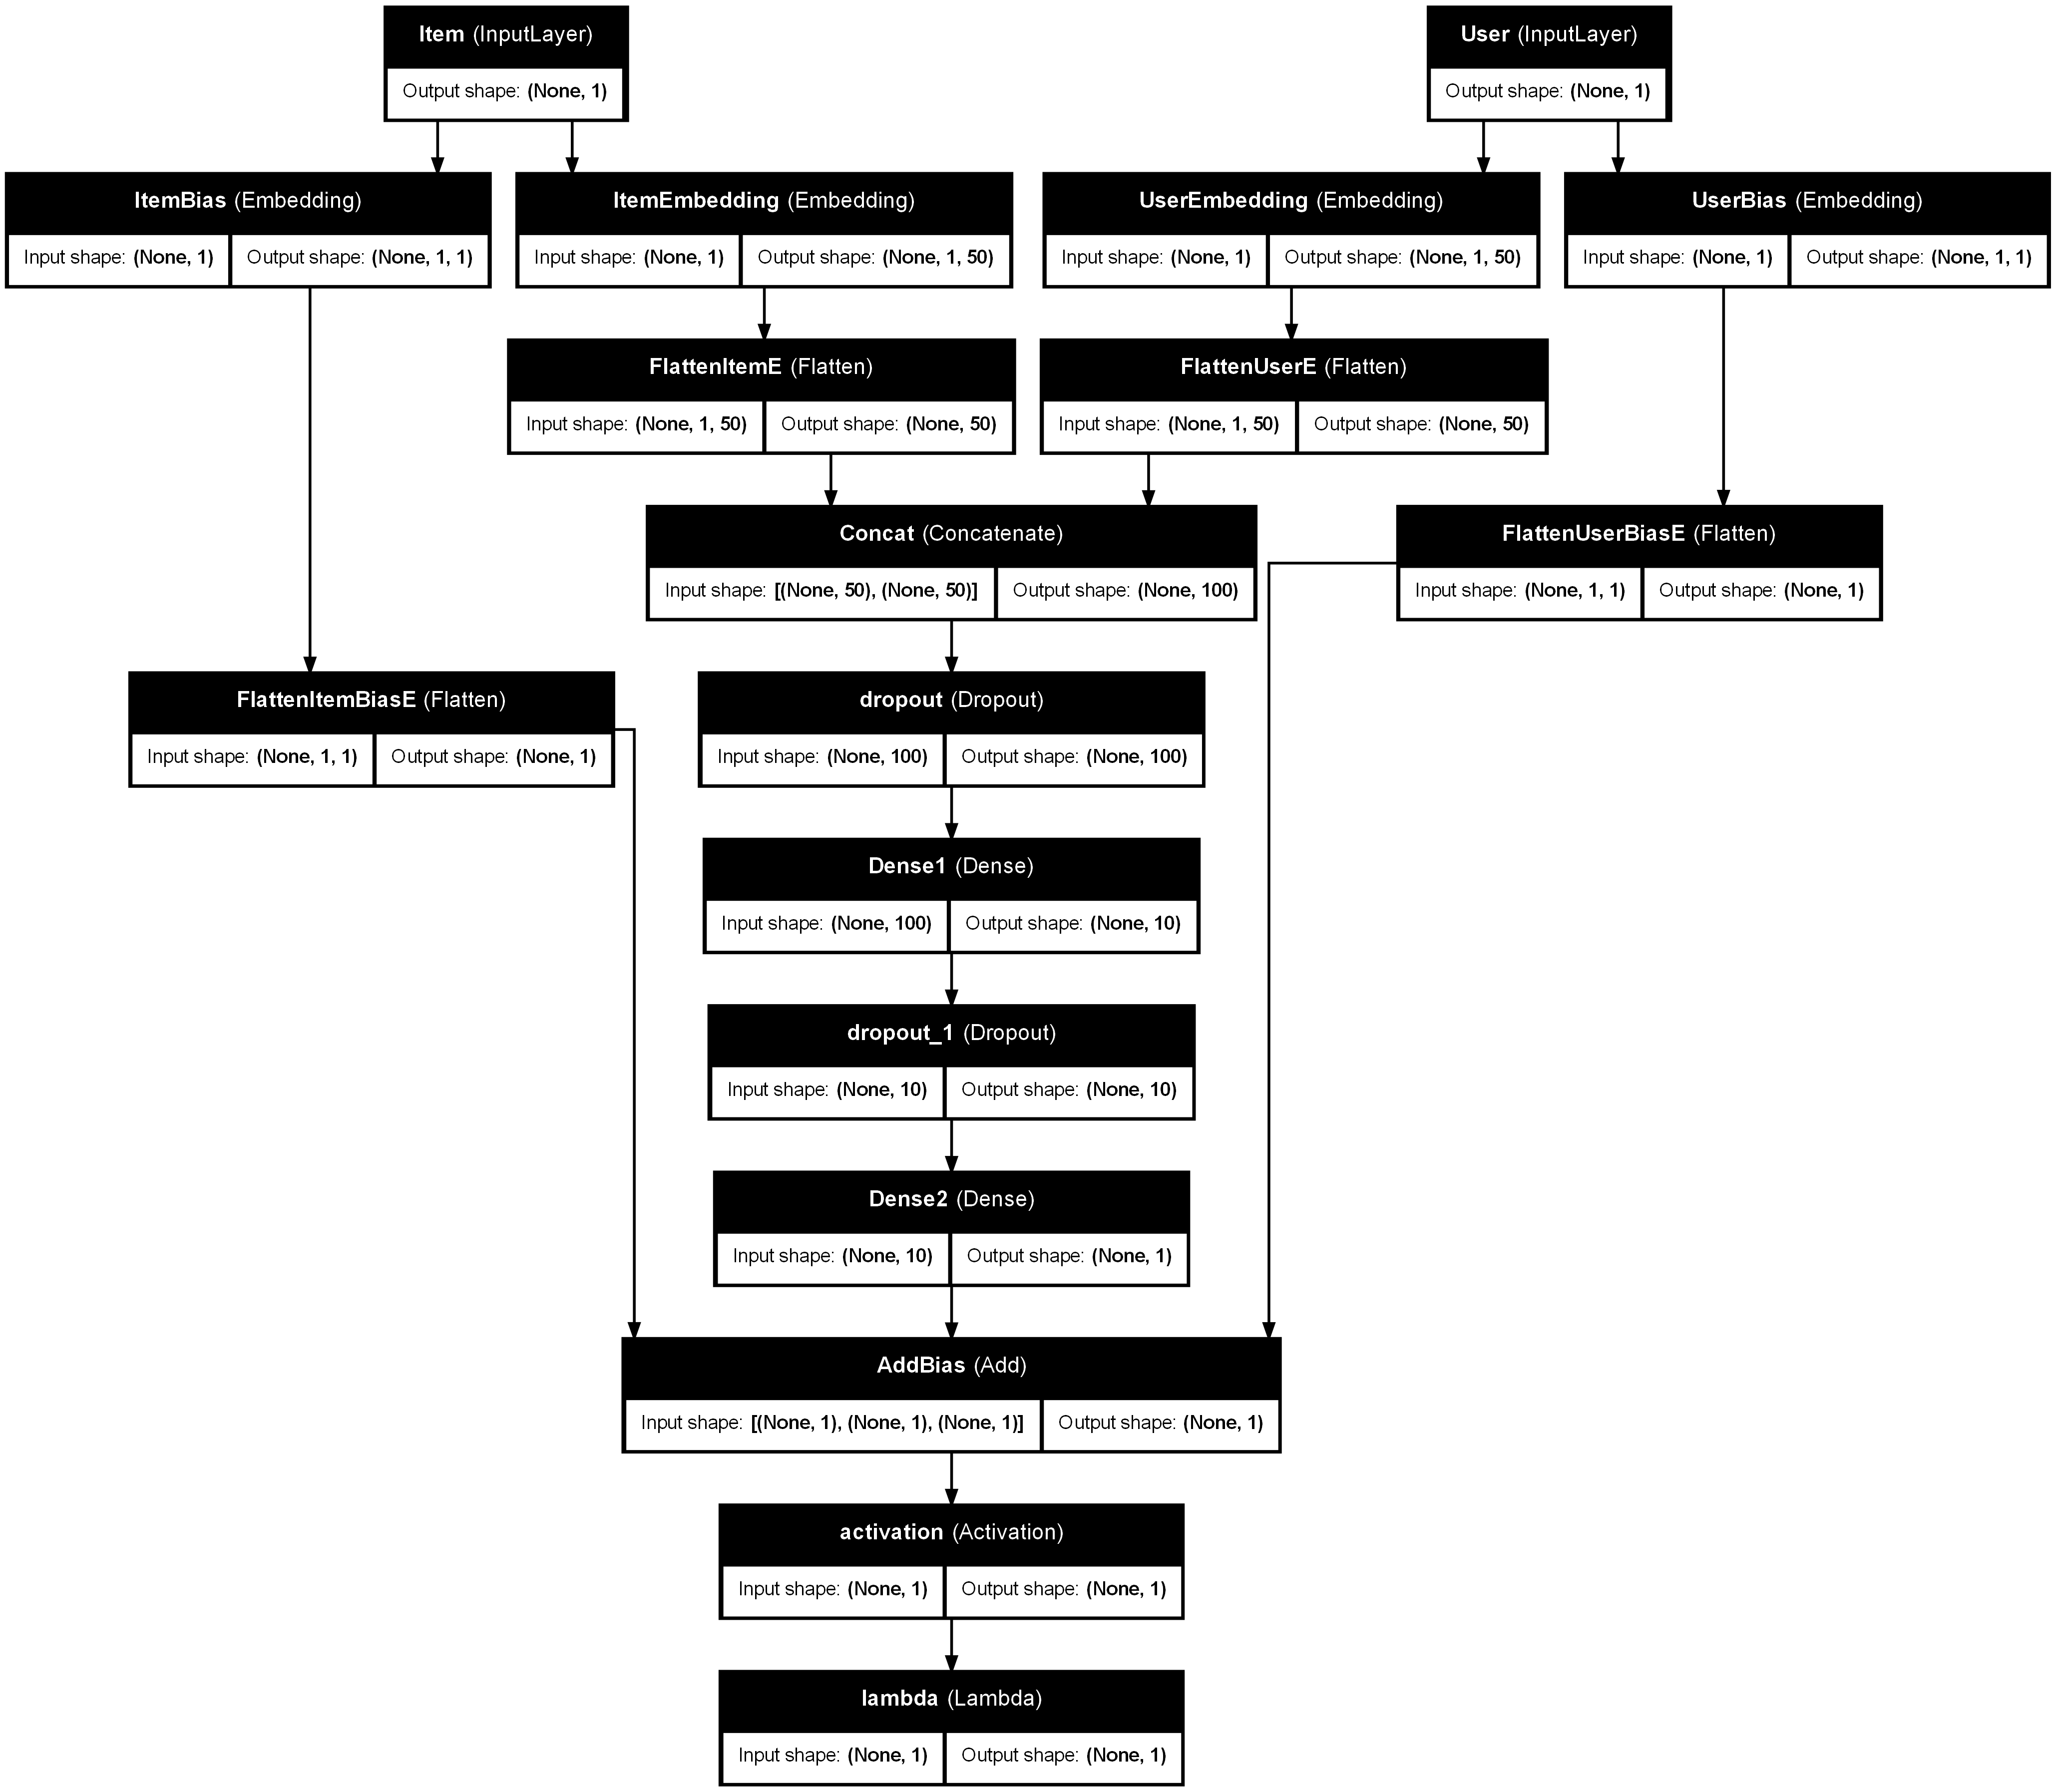

In [26]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/Deep-CF.png" )

### Train the Model

In [27]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, 
                   validation_data= ([test.USER, test.ITEM], test.RATING))

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.1822 - val_loss: 0.9019
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9343 - val_loss: 0.8946
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9012 - val_loss: 0.8912
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8809 - val_loss: 0.8877
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8807 - val_loss: 0.8875
Wall time: 22.5 s


In [28]:
#vis.metrics(output.history)

### Score the Model

In [29]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9146


0.8875109553337097

### Evaluate the Model

In [30]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [31]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [32]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step
Wall time: 2min 27s


In [33]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.112962
1,195,301,4.239017
2,195,376,2.398520
3,195,50,3.509337
4,195,345,3.750486


In [34]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step
Wall time: 2min 3s


In [35]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.021589
Precision@K:	0.015801
Recall@K:	0.011684


### Get Similar Items

In [36]:
from reco.recommend import get_similar, show_similar

In [37]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 213 ms


In [38]:
item_similar_indices

array([[   0, 1201, 1514, 1185, 1572],
       [   1, 1656, 1121, 1639, 1629],
       [   2, 1353, 1674, 1565, 1328],
       ...,
       [1679, 1347, 1670, 1600, 1362],
       [1680, 1639, 1644, 1629, 1121],
       [1681, 1121, 1644, 1629, 1639]], dtype=int64)

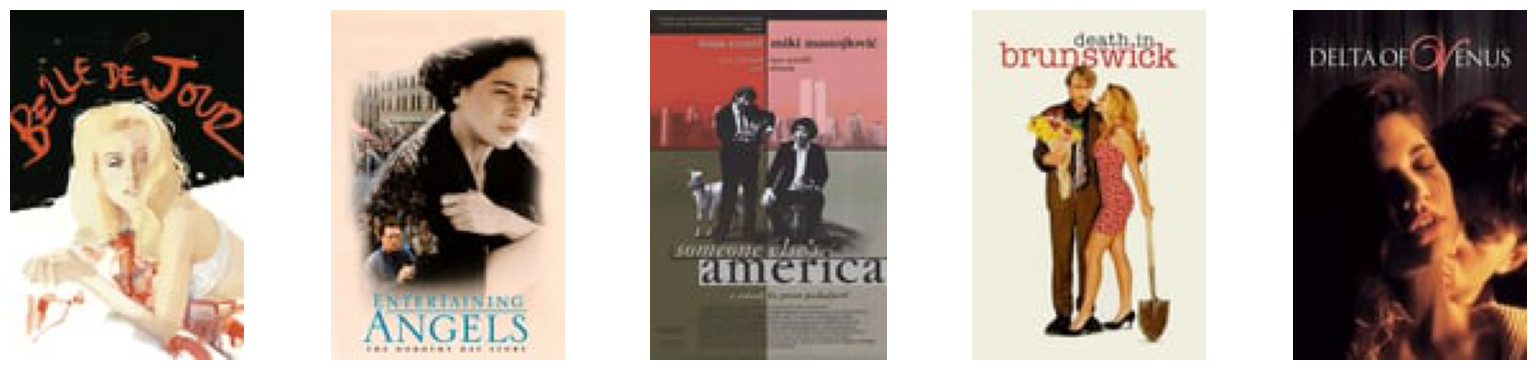

In [40]:
show_similar("Batman Forever", item_similar_indices, item_encoder, df_items)